<a href="https://colab.research.google.com/github/ptran1203/face_recognition/blob/master/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive, output
data_loaded = False
# drive.mount('/content/drive')
BASE_DIR = "/content/drive/My Drive/face_recognition"
!rm -rf '/content/face_recognition'
!git clone https://github.com/ptran1203/face_recognition
!pip install face_recognition

Cloning into 'face_recognition'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 342 (delta 102), reused 305 (delta 65), pack-reused 0
Receiving objects: 100% (342/342), 13.68 MiB | 44.33 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [ ]:
cd face_recognition

/content/face_recognition


Read data from directory
'NoneType' object is not iterable
Face not found in image ./dataset/sontung/030.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/sontung/016.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/sontung/008.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/sontung/015.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/sontung/011.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/phat/008.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/phat/005.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/baejun/022.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/baejun/021.jpg
'NoneType' object is not iterable
Face not found in image ./dataset/thaotam/019.jpg
Done, 148 images were loaded


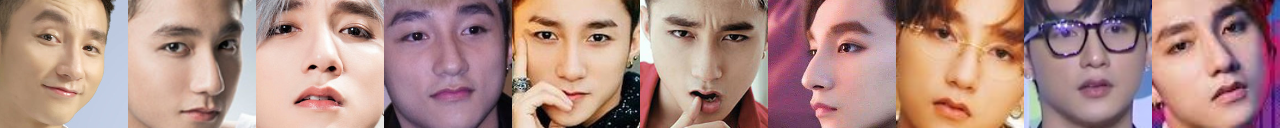

(103,) (103,)


In [ ]:
from dataloader import *
from model import *
from utils import *
from face_localization import *

import tensorflow as tf

data_path = "./dataset/"

class FaceRecognizer(FaceModel):
    pass

    

class DataGen(DataGenerator):
    pass

rst = 128
data_gen = DataGen(data_path, 128, rst)
fmodel = FaceRecognizer(rst, len(data_gen.classes), lr=1e-5)

In [ ]:
fmodel.train(data_gen, epochs=5)
fmodel.calculate_embeddings(data_gen.x, data_gen.y)
fmodel.evaluate(data_gen.x_test, data_gen.y_test)

Epoch 1/5
32/32 [==============================] - 8s 262ms/step - loss: 0.8527
Epoch 2/5
32/32 [==============================] - 9s 266ms/step - loss: 0.3063
Epoch 3/5
32/32 [==============================] - 8s 262ms/step - loss: 0.0403
Epoch 4/5
32/32 [==============================] - 8s 259ms/step - loss: 8.4411e-05
Epoch 5/5
32/32 [==============================] - 8s 259ms/step - loss: 0.0000e+00


0.7555555555555555

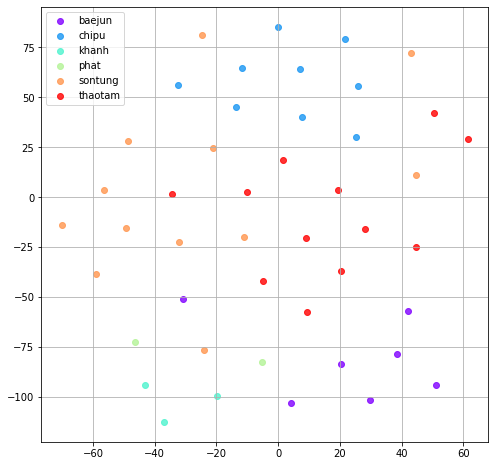

In [ ]:
scatter_plot(data_gen.x_test, data_gen.labels_test,
             fmodel.embedding, opt='tsne', plot_img=0,
             figsize=(15,15), image_zoom=0.6,)

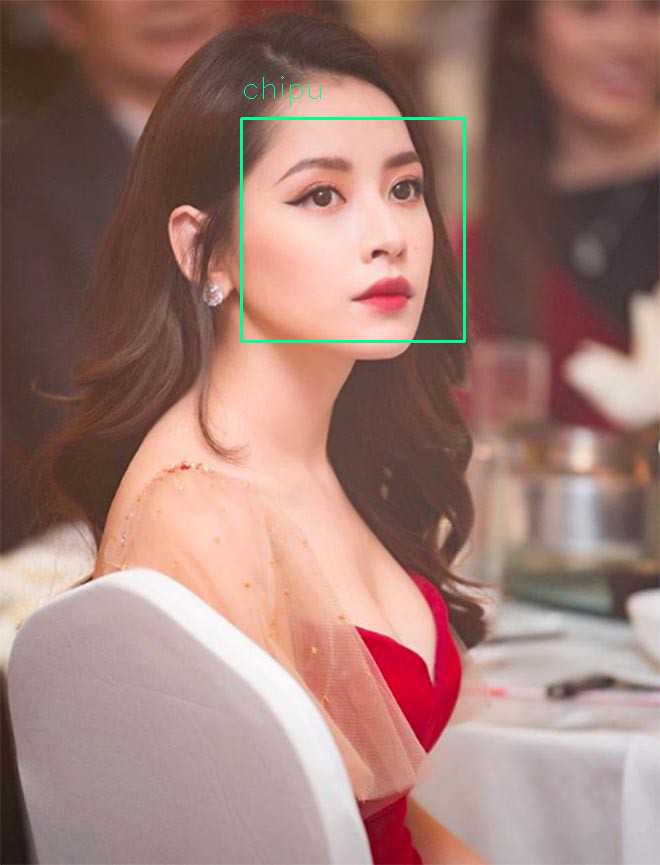

In [ ]:
img, bbox, face = readimg(
    'https://image-us.24h.com.vn/upload/4-2019/images/2019-10-04/1570160901-402-chi-pu-2111-1569316737-width660height865.jpg',
    get_face=True, normalize=False,
    preprcs=False,size=128,
)

def draw_bbox(img, coordinates, text='face', color=(0,0,0)):
    "The pixcel's range should be [0, 255]"
    x, y, w, h = coordinates
    cv2.rectangle(img,(x, y),(x + w, y + h), color, 2)
    return cv2.putText(img, text,(x + w, y - 20), 0, 1, color)

if img is not None:
    x, y, ex, ey = bbox
    
    pred = fmodel.get_prediction(norm(np.expand_dims(face, 0)),
                                 data_gen.labels)
    result = draw_bbox(img, (x,y,ex,ey), pred, (148, 252, 3))
    cv2_imshow(result)

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGB')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
size=128
def extract_face(image, return_bbox=False, face_scale_thres = (20, 20)):
    h, w = image.shape[:2]

    try:
        (startY, startX, endY, endX) = extract_box(image)
    except Exception as e:
        return None

    minX, maxX = min(startX, endX), max(startX, endX)
    minY, maxY = min(startY, endY), max(startY, endY)
    face = image[minY:maxY, minX:maxX].copy()
    # extract the face ROI and grab the ROI dimensions
    (fH, fW) = face.shape[:2]
    # ensure the face width and height are sufficiently large
    if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
        return None

    if return_bbox:
        return face, (startX, startY, endX - startX, endY - startY)

    return face

while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    face = extract_face(image, True)
    if face is not None:
        face, bbox = face
        face = cv2.resize(face, (size, size))
        x, y, ex, ey = bbox
        pred = fmodel.get_prediction(norm(np.expand_dims(face, 0)),
                                    data_gen.labels)
        img_array = draw_bbox(image, (x,y,ex,ey), pred, (148, 252, 3))
    else:
        img_array = image

    # # print(img_array.shape)
    # img_array[:,:,3] = (img_array.max(axis = 2) > 0 ).astype(int)
    # img_data = img_array
    img_data = drawing_array_to_bytes(img_array)
